# Datová analýza exoplanetárního datasetu</h1>
## Semestrální práce z předmětu 4ST101
### *Autor: Jakub Vítovec*

## Úvod
Ve své semestrální práci se budu zabývat daty získanými z veřejné databáze [Keggle](https://www.kaggle.com/). Konkrétní dataset je dostupný na URL [https://www.kaggle.com/datasets/sathyanarayanrao89/nasa-exoplanetary-system](https://www.kaggle.com/datasets/sathyanarayanrao89/nasa-exoplanetary-system) a byl vytvořen uživatelem Sathyanarayan Rao z dat publikovaných vesmírnou agenturou NASA. Celkem se v datasetu nachází 32552 různých dosud objevených exoplanet a základní data o nich.
Exoplaneta je planeta, která obíhá okolo jiné hvězdy, než okolo Slunce. První exoplaneta byla objevena v roce 1998 a počet jejich počet stále roste. Ve své semestrální práci bych se rád zaměřil na trend růstu či poklesu počtu objevených nových exoplanet a zapojení různých vědeckých zařízení při jejich objevování.

### Představení dat a jejich čištění
V tomto oddíle si představíme zpracovávaná data a vyčistíme je od nežádoucích hodnot.

In [51]:
import pandas as pd;
import matplotlib.pyplot as plt;
import numpy as np;

dataset = pd.read_csv("./exoplanets_dataset.csv");
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32552 entries, 0 to 32551
Data columns (total 93 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Unnamed: 0                               32552 non-null  int64  
 1   Planet Name                              32552 non-null  object 
 2   Host Name                                32552 non-null  object 
 3   Number of Stars                          32552 non-null  int64  
 4   Number of Planets                        32552 non-null  int64  
 5   Discovery Method                         32552 non-null  object 
 6   Discovery Year                           32552 non-null  int64  
 7   Discovery Facility                       32552 non-null  object 
 8   Orbital Period [days]                    29747 non-null  float64
 9    Planet Radius [Earth Radius]            22711 non-null  float64
 10  Planet Mass or Mass*sin(i) [Earth Mass]  4699 

Jak vidíme dataset obsahuje značné množství nepojmenovaných sloupců - Unnamed. Ty z datasetu odstraníme jako první.

In [52]:
for column_name in dataset.columns:
    if ("Unnamed" in column_name):
        del dataset[column_name];

Jako další by bylo vhodné zkontrolovat počty chybějících hodnot v jednotlivých sloupcích.

In [53]:
print(dataset.isnull().sum());

Planet Name                                    0
Host Name                                      0
Number of Stars                                0
Number of Planets                              0
Discovery Method                               0
Discovery Year                                 0
Discovery Facility                             0
Orbital Period [days]                       2805
 Planet Radius [Earth Radius]               9841
Planet Mass or Mass*sin(i) [Earth Mass]    27853
 Eccentricity                              15902
dtype: int64


Nejvíce chybějících hodnot se nachází ve sloupcích Planet Mass or Mass*sin(i), Eccentricity a Planet Radius, které obsahují hmotnost planety, ekcentricitu její oběžné dráhy a jejich poloměr. Vzhledem k tomu, že značná část těchto dat nám chybí, tak nebudeme tyto hodnoty využívat a sloupce odstraníme.

In [54]:
columns_to_delte = [" Planet Radius [Earth Radius]", "Planet Mass or Mass*sin(i) [Earth Mass]",  " Eccentricity"]

for column_name in dataset.columns:
    if (column_name in columns_to_delte):
        del dataset[column_name];

Jako další odstraníme z datasetu duplikované hodnoty.

In [55]:
print("Deleted duplicate values: " + str(dataset.duplicated().sum()));
dataset.drop_duplicates();

Deleted duplicate values: 11305


Po odstranění sloupců se značným počtem chybějících hodnot nám v datasetu zůstaly následující proměnné:
- **Planet Name** - Obsahuje jméno dané exoplanety
- **Host Name** - Jméno hostující hvězdy
- **Number of Stars** - Počer hvězd v planetárním systému dané exoplanety (u Země 1)
- **Number of Planets** - Počet planet v planetárním systému dané exoplanety (u Země 8)
- **Discovery Method** - Způsob objevení planety
- **Discovery Year** - Rok objevení planety
- **Discovary Facility** - Zařízení, které objevilo danou planetu
- **Orbital Period** - Orbitální perioda, doba v letech, za kterou planeta oběhne svou hostující hvězdu (Host Name)

## Teoretická část
V této části se zaměřím na statistické veličiny, které budou použity k analýze našeho datového souboru.
Jako základní veličinu míry polohy použijeme aritmetický průměr. Náš soubor obsahuje jak spojité, tak diskrétní náhodné veličiny. Ačkoliv jsou spojité fyzikální veličiny při reálných měřeních často interpretovány jako diskrétní, vzhledem k tomu, že rozptyl u planetárních měření je zpravidla podstatně větší, než nejmenší rozlišitelná hodnota, tak bude vhodné tuto veličinu považovat za spojitou.

- Aritmetický průměr spojité náhodné veličiny *E(x)* spočítáme jako:
$$E(x)=\int_{D(f)}xf(x)dx$$

- Aritmetický průměr diskrétní náhodné veličiny *E(x)* spočítáme jako:
$$E(x)=1/N\displaystyle\sum\limits_{i=0}^N x_{i}$$

Vzhledem k tomu, že jsme se rozhodli zkoumat tredy vývoje objevování nových planet, tak budeme potřebovat statistickou veličinu, kterou tento vývoj kvantifikujeme. K tomu je vhodné použít řetězové a bazické indexy. Pomocí nich můžeme snadno měřit růst či pokles dané veličiny mezi po sobě jdoucími obdobími nebo vůči nějakému základnímu období.

- Řetězový index růstu veličiny *x* spočítáme jako:
$$I_{t-1}^{t}=\frac{x_{t}}{x_{t-1}}$$

- Bazický index růstu veličiny *x* vůči pevnému základu spočítáme jako:
$$I_{t_{0}}^{t}=\frac{x_{t}}{x_{t_{0}}}$$

Když jsme zavedli aritmetický průměr pro měření polohy a indexy pro zkoumání trendů, bude vhodné zavést také možnost, jak spočítat průměr nějakých indexů za dané období, tím získáme střední hodnotu růstu či poklesu dané proměnné. K průměrování indexů se používá geometrický průměr, ten je definován, jako n-tá odmocnina z produktu daných čísel.

- Geometrický průměr spočítáme jako:
$$E_{g}(x)=\left(\prod _{{i=1}}^{{n}}x_{i}\right)^{{{\frac {1}{n}}}}$$

K zobrazení rozdělení četnosti použijeme histogram. Histogram je druh sloupcového grafu, který znázorňuje distribuci dat tak, že výška sloupce určuje četnost dané veličiny. U histogramu je kritické určení šířky intervalů (počtu tříd), do kterých dané četnosti rozdělíme. Pro Určení počtu tříd použijeme doporučený vztah
$$k=\lceil2.46(N-1)^{0,4}\rceil$$

Díky histogramu budeme schopni vizualizovat množství planet objevených jednotlivými zařízeními i vývoj počtu nově oběvených planet.



## Praktická část
V rámci praktické části se zaměříme na samotné zpracování dat, pomocí kterého budeme zkoumat trendy v počtech nových objevených exoplanet. Pro zkoumání četností nově objevených planet v daných letech si musíme nejprve sestavit nový DataFrame obsahující počty planet objevené v daných letech. Dále sestavíme řetězový index tohoto sloupce a určíme jeho směrodatnou odchylku, aritmetický průměr a variační koeficient, abychom zjistili, jak moc se od sebe hodnoty vzájemě liší.

In [56]:
planet_discovery_frequencies = dataset.groupby("Discovery Year")["Planet Name"].count().reset_index(name="Frequency");
planet_discovery_frequencies["F/F-1"] = planet_discovery_frequencies["Frequency"]/planet_discovery_frequencies["Frequency"].shift(1);
print("Variační koeficient počtu nově objevených exoplanet ročně: " + str(planet_discovery_frequencies["Frequency"].std()/planet_discovery_frequencies["Frequency"].mean()))
planet_discovery_frequencies["Frequency"].describe()

Variační koeficient počtu nově objevených exoplanet ročně: 2.5629218786861627


count       31.000000
mean      1050.064516
std       2691.233322
min          2.000000
25%         62.000000
50%        232.000000
75%        765.500000
max      12718.000000
Name: Frequency, dtype: float64

Ze získaných hodnot je patrné, že variační koeficient je velice vysoký (přibližně 256%), tím pádem pro nás aritmetický průměr není vypovídající statistickou veličinou. Zároveň můžeme vypozorovat, že se maximum danového souboru nachází vysoko nad hodnotou třetího kvartilu, to nám indikuje, že exisuje několik málo roků, během kterých bylo objeveno neobvykle mnoho exoplanet. Abychom mohli vizuálně posoudit počty objevených planet v jednotlivých letech, vytvoříme histogram. Vzhledem k obrovskému variačnímu rozpětí souboru a vysokému variačnímu koeficientu bude na osu *y* znázorňující počet objevených planet vhodné použít logaritmické měřítko, díky němu bude mezi vzdálenými hodnotami graficky menší vzdálenost a celý graf bude přehlednější

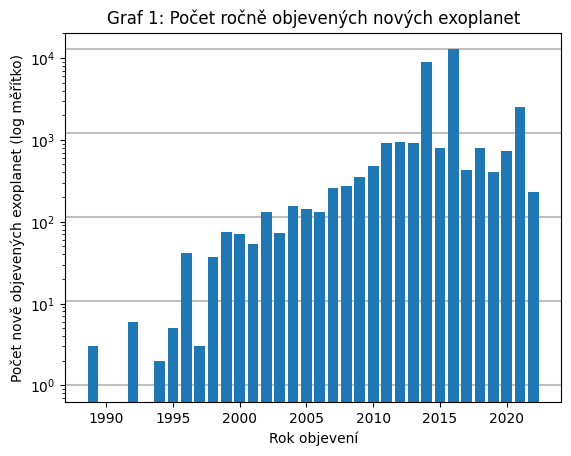

0


In [60]:
plt.bar(planet_discovery_frequencies['Discovery Year'], planet_discovery_frequencies['Frequency'])
plt.xlabel('Rok objevení')
plt.ylabel('Počet nově objevených exoplanet (log měřítko)')
plt.title('Graf 1: Počet ročně objevených nových exoplanet')
plt.yscale('log');
y_vals = np.logspace(np.log10(1), np.log10(max(planet_discovery_frequencies['Frequency'])), num=5, endpoint=True, base=10)
for y_val in y_vals:
    plt.axhline(y=y_val, color='gray', linestyle='-', alpha=0.5, zorder=0)

plt.show()


Z Grafu 1. lze vyčíst, že data vykazují poměrně přirozený, vizuálně až logaritmický růst, s výjimkou let 2014 a 2016, během kterých bylo objevenou 8822 a 12718 nových exoplanet. Počty objevené jenom v těchto dvou letech tvoří podstatnou část všech objevených exoplanet, proto nemůžeme tyto hodnoty ignorovat a pokusíme se zodpovědět, co stojí za těmito počty. Vytvoříme si dva nové DataFramy obsahující planety objevené v letech 2014 & 2016 a všechny ostatní, seskupíme je podle vědeckého zařízení, které je objevilo a nalezneme 5 nejvyšších hodnot.

In [83]:
critical_years_planets = dataset[dataset["Discovery Year"].astype(str).str.contains("2014|2016")]
non_critical_years_planets = dataset[~dataset["Discovery Year"].astype(str).str.contains("2014|2016") ]
print(non_critical_years_planets.groupby("Discovery Facility")["Planet Name"].count().reset_index(name="Planets Discovered").sort_values("Planets Discovered").tail());
print(critical_years_planets.groupby("Discovery Facility")["Planet Name"].count().reset_index(name="Planets Discovered").sort_values("Planets Discovered").tail());

        Discovery Facility  Planets Discovered
27    La Silla Observatory                 491
49               SuperWASP                 493
57  W. M. Keck Observatory                 553
19                      K2                1218
25                  Kepler                5513
        Discovery Facility  Planets Discovered
7                 HATSouth                  48
20  Multiple Observatories                  67
25               SuperWASP                 125
9                       K2                 551
13                  Kepler               20510
